# Test SOM with CNN

In [33]:
import tensorflow as tf
from tensorflow.python.tools import inspect_checkpoint as chkp
from tensorflow.python.platform import gfile
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
import random
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import somoclu
import deep_som as ds
import time
import matplotlib.cm as cm
from pathlib import Path
import pprint, pickle

%matplotlib inline

## 1 - Load CNN

In [2]:
checkpoint_directory = r"C:\tmp\speech_commands_train"
checkpoint_name = "conv.ckpt-18000"
graph_name = "conv.pbtxt"

In [3]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))   

### Load the  model graph and restore last checkpoint

In [4]:
sess=tf.Session()   
saver = tf.train.import_meta_graph(os.path.join(checkpoint_directory, checkpoint_name + ".meta"))
saver.restore(sess,os.path.join(checkpoint_directory, checkpoint_name))

INFO:tensorflow:Restoring parameters from C:\tmp\speech_commands_train\conv.ckpt-18000


### Show the graph (beter use tensorboard)

graph = tf.get_default_graph()
graph_def = graph.as_graph_def()
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))# show_graph(tmp_def)

### Init model settings

In [6]:
sample_rate = 16000
clip_duration_ms = 1000
window_size_ms = 30.
window_stride_ms = 10.
dct_coefficient_count = 40

desired_samples = int(sample_rate * clip_duration_ms / 1000)
window_size_samples = int(sample_rate * window_size_ms / 1000)
window_stride_samples = int(sample_rate * window_stride_ms / 1000)
length_minus_window = (desired_samples - window_size_samples)
if length_minus_window < 0:
    spectrogram_length = 0
else:
    spectrogram_length = 1 + int(length_minus_window / window_stride_samples)
fingerprint_size = dct_coefficient_count * spectrogram_length

model_settings = {
      'desired_samples': desired_samples,
      'window_size_samples': window_size_samples,
      'window_stride_samples': window_stride_samples,
      'spectrogram_length': spectrogram_length,
      'dct_coefficient_count': dct_coefficient_count,
#      'fingerprint_size': fingerprint_size,
#       'label_count': label_count,
      'sample_rate': sample_rate,
  }
print(model_settings)

{'desired_samples': 16000, 'window_size_samples': 480, 'window_stride_samples': 160, 'spectrogram_length': 98, 'dct_coefficient_count': 40, 'sample_rate': 16000}


## 2 - Build preprocesing graph

In [7]:
wav_data_placeholder = tf.placeholder(tf.string, [], name='wav_data')
audio_binary = tf.read_file(wav_data_placeholder)
decoded_sample_data = contrib_audio.decode_wav(
  audio_binary,
  desired_channels=1,
  desired_samples=model_settings['desired_samples'],
  name='decoded_sample_datal')
spectrogram = contrib_audio.audio_spectrogram(
  decoded_sample_data.audio,
  window_size=model_settings['window_size_samples'],
  stride=model_settings['window_stride_samples'],
  magnitude_squared=True)
fingerprint_input = contrib_audio.mfcc(
  spectrogram,
  decoded_sample_data.sample_rate,
  dct_coefficient_count=dct_coefficient_count)
fingerprint_frequency_size = model_settings['dct_coefficient_count']
fingerprint_time_size = model_settings['spectrogram_length']
reshaped_input = tf.reshape(fingerprint_input, [
  -1, fingerprint_time_size * fingerprint_frequency_size
  ])

## 3 - Run preprocessing graph and show example

In [8]:
wav_fname = r"C:\tmp\speech_dataset\dog\00f0204f_nohash_1.wav"

fingerprint_input_val = sess.run(reshaped_input, feed_dict={wav_data_placeholder: wav_fname})

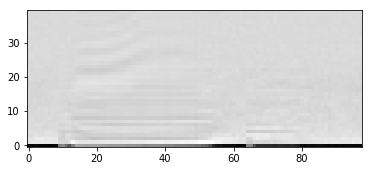

In [9]:
mfcc = sess.run(fingerprint_input, feed_dict={wav_data_placeholder: wav_fname})
plt.imshow(mfcc.T.squeeze(), origin='lower', cmap='gray')
plt.show()

## 4 - Define tensor to pick activations from

In [27]:
op_names = [op.name for op in graph.get_operations()]
checked_op_name = "MatMul"
op_to_restore = graph.get_tensor_by_name(checked_op_name+":0")
input_dict = {
              "dropout_prob:0" : 1.0,
              "fingerprint_input:0" : fingerprint_input_val
             }
output = np.squeeze(sess.run(op_to_restore, feed_dict=input_dict))

In [28]:
print(len(output))
print(np.sum(output))
print(np.max(output))
print(np.min(output))

200
-10.531021
3.5794277
-4.2223425


## 5 - Create training set

In [50]:
db_directory = Path(r"C:\Study\DB\SpeechCommands")
ignore_list = [
    r"C:\Study\DB\SpeechCommands\_background_noise_"
]
train_size = 10000

random.seed(1)
file_list = [f for f in db_directory.resolve().glob('**/*') if f.is_file() and f.suffix == '.wav'  and 
             all(ignore_obj not in str(f) for ignore_obj in ignore_list)]

random.shuffle(file_list)
file_list = file_list[:train_size]
labels = [p.parent.stem for p in file_list]
training_set = []

for i, fname in enumerate(file_list):
    print("\rprocessing {} out of {}...".format(i, len(file_list)), end='')
    fingerprint_input_val = sess.run(reshaped_input, feed_dict={wav_data_placeholder: str(fname)})
    input_dict = {
              "dropout_prob:0" : 1.0,
              "fingerprint_input:0" : fingerprint_input_val
             }
    output = np.squeeze(sess.run(op_to_restore, feed_dict=input_dict))
    training_set.append(output)

print(" done")

training_set = np.array(training_set)

processing 9999 out of 10000... done


### Save training set

In [ ]:
with open('cnn_200_training.pickle', 'wb') as f:
    pickle.dump({"input": training_set, 
                 "out": labels}, f, pickle.HIGHEST_PROTOCOL)
print("training set saved")

training set saved


### Loading training set

In [52]:
print("loading training set")
with open('cnn_200_training.pickle', 'rb') as f:
    train = pickle.load(f)
training_set = train["input"]
labels = train["out"]

loading training set


## 6 - Init and run SOM

init dsom
training
training 1 layer out of 1
saving som
som saved
plotting result


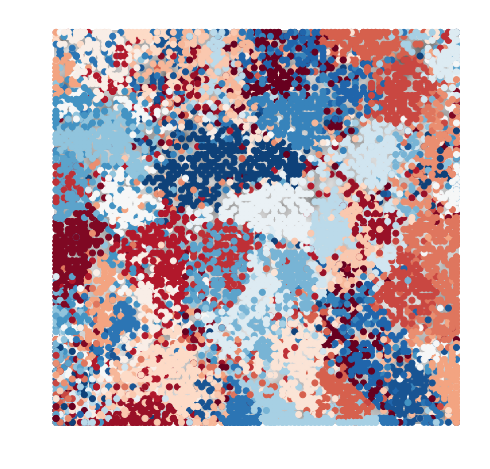

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [53]:
cmap = plt.cm.get_cmap('RdBu')
labels_set = set(labels)
colors_list = [cmap(float(i) / len(labels_set)) for i in range(len(labels_set))]

label_to_color = dict(zip(labels_set, colors_list))

colors = []
for i, l in enumerate(labels):
    colors.append(label_to_color[l])
    
print("init dsom")
dsom = ds.DeepSom()
dsom.add_layer(100, 100, 200)

print("training")
dsom.train(training_set, verbose=1)

print("saving som")
with open('som_with_cnn_200.pickle', 'wb') as f:
    pickle.dump(dsom, f, pickle.HIGHEST_PROTOCOL)
print("som saved")

print("plotting result")
dsom._layers["som_0"].view_umatrix(colormap=cm.binary, bestmatches=True, bestmatchcolors=colors)